## Notes

If it stalls around loss 60, you might need a smaller batch size, e.g. 8



## Log

### 20180506
Why is this not working? It stalls around loss=60 and just reconstructs the same mean image each time.

- batchnorm and pad? no lots of other models use them
    - https://github.com/josephsmann/UnsupervisedDeepLearning-Pytorch/blob/jm/udlp/autoencoder/convVAE.py#L19
    - https://github.com/taey16/pix2pixBEGAN.pytorch/blob/master/models/BEGAN.py
- relu, same
- lr - similar to other models
- inner params - similar but larger than other working models
- batch? Maybe it seems better with a lower batch (e.g. 8 instead of 32)
- loss, this seems right
    - except some people use a loss balance https://github.com/AppliedDataSciencePartners/WorldModels/blob/master/vae/arch.py#L97
        where they multuply reconstruction loss by 10 but i've got ~100 vs ~1e-4 so I don't really need to!
        
- ok a lower batch size seemed to get it over that initial hump

In [1]:
import os
os.sys.path.append('.')

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from vae import VAE4, loss_function
from helpers.summarize import TorchSummarizeDf
from helpers.dataset import NumpyDataset, TQDMDaskProgressBar, load_npzs

In [5]:
env_name='sonic256'

cuda= torch.cuda.is_available()

num_epochs=200
image_size=256
chunksize=1000
batch_size=16

data_cache_file = '/tmp/sonic_vae256.hdf5'

# Load data

In [6]:
# load as dask array

filenames = sorted(glob.glob('./data/vae/obs_data_' + env_name + '_*.npz'))

if not os.path.isfile(data_cache_file):
    data_train = load_npzs(filenames)
    print(data_train)
    with TQDMDaskProgressBar():
        da.to_hdf5(data_cache_file, '/x', data_train)
       
    # clear mem
    del data_train 
    import gc
    gc.collect()

In [7]:
# load
data = da.from_array(h5py.File(data_cache_file, mode='r')['x'], chunks=(chunksize, image_size, image_size, 3))
data
data_split = int(len(data)*0.8)
data_train = data[:data_split]
data_test = data[data_split:]
data_train, data_test

(dask.array<getitem, shape=(62400, 256, 256, 3), dtype=float32, chunksize=(1000, 256, 256, 3)>,
 dask.array<getitem, shape=(15600, 256, 256, 3), dtype=float32, chunksize=(600, 256, 256, 3)>)

In [8]:
   
dataset_train = NumpyDataset(data_train)
loader_train = torch.utils.data.DataLoader(dataset_train, pin_memory=True, shuffle=False, batch_size=batch_size)


dataset_test = NumpyDataset(data_test)
loader_test = torch.utils.data.DataLoader(dataset_test, pin_memory=True, shuffle=False, batch_size=batch_size)

dataset_train, loader_train

(<helpers.dataset.NumpyDataset at 0x7fd6734a7a20>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd6734a79e8>)

# View model

In [9]:

vae = VAE4(image_size=image_size, z_dim=1024, conv_dim=64, code_dim=2, k_dim=512)
if cuda:
    vae.cuda()

In [10]:
# # Resume?
NAME='VAE4_2x256'
save_file = f'./models/{NAME}_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(f'./models/{NAME}_state_dict.pkl')
    vae.load_state_dict(state_dict)
    print(f'loaded {save_file}')

loaded ./models/VAE4_2x256_state_dict.pkl


In [11]:
img = np.random.randn(image_size, image_size, 3)
gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float()
if cuda:
    gpu_img = gpu_img.cuda()
with TorchSummarizeDf(vae) as tdf:
    x, mu, logvar = vae.forward(gpu_img)
    print(x.size())
    print(loss_function(x, gpu_img, mu, logvar))
    x = x.data.cpu().numpy()[0].transpose(1, 2, 0)
    df = tdf.make_df()
    
df[df.level<2]

torch.Size([1, 3, 256, 256])
tensor(1.00000e+05 *
       [ 2.0065], device='cuda:0')
Total parameters 29383555
Total trainable parameters 29383555


,name,class_name,input_shape,output_shape,nb_params,level
4,encoder.0,ConvBlock4,"[(-1, 256, 256)]","[(-1, 256, 256)]",1920,1
8,encoder.1,ConvBlock4,"[(-1, 256, 256)]","[(-1, 128, 128)]",131456,1
12,encoder.2,ConvBlock4,"[(-1, 128, 128)]","[(-1, 64, 64)]",393792,1
16,encoder.3,ConvBlock4,"[(-1, 64, 64)]","[(-1, 32, 32)]",787200,1
20,encoder.4,ConvBlock4,"[(-1, 32, 32)]","[(-1, 16, 16)]",1311680,1
24,encoder.5,ConvBlock4,"[(-1, 16, 16)]","[(-1, 8, 8)]",1967232,1
28,encoder.6,ConvBlock4,"[(-1, 8, 8)]","[(-1, 4, 4)]",2753856,1
32,encoder.7,ConvBlock4,"[(-1, 4, 4)]","[(-1, 2, 2)]",3671552,1
33,encoder.8,Conv2d,"[(-1, 2, 2)]","[(-1, 2, 2)]",525312,1
34,mu,Linear,"[(-1,)]","[(-1,)]",2097664,0


## Train

In [12]:
import collections

def train(loader, net, optimizer, loss_function, test=False, cuda=True):
    if test:
        net.eval()
    else:
        net.train()
    info = collections.defaultdict(list)
    
    with tqdm(total=len(loader)*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i, (batch,) in enumerate(loader):
            x = Variable(batch.transpose(1,3))
            if cuda:
                x=x.cuda()
            y, mu, logvar = vae.forward(x)
            loss = loss_function(y, x, mu, logvar).mean()
            info['loss'].append(loss.cpu().data.numpy())
            
            if not test:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            prog.update(loader.batch_size)
            prog.desc='loss={:2.4f}'.format(np.mean(info['loss']))
            
#             if i%(200000//batch_size)==0:
#                 print('[{}/{}] loss={:2.4f}'.format(i, len(loader), np.mean(info['loss'][-300:])))
        print('[{}/{}] loss={:2.4f}'.format(i, len(loader), np.mean(info['loss'])))
        prog.close()
    return info

In [13]:
# Plot reconstructions
def plot_results(loader=loader_test, n=2, epoch=0):
    x, = next(iter(loader))

    X = Variable(x).transpose(1,3).contiguous()
    if cuda:
        X = X.cuda()
    Y, mu, logvar = vae.forward(X)
    loss = loss_function(Y, X, mu, logvar)

    y=Y.cpu().data.transpose(1,3).numpy()
    for i in range(n):
        plt.figure(figsize=(6,3))
        plt.subplot(1, 2, 1)
        plt.title('original')
        plt.axis('off')
        plt.imshow(x[i].numpy())

        plt.subplot(1, 2, 2)
        plt.imshow(y[i])
        plt.axis('off')
        plt.title('reconstructed')

        plt.suptitle('epoch {}, index {}, loss {:2.4f}'.format(epoch, i, loss[i].cpu().data.numpy()))
        plt.show()
        
# plot_results(loader=loader_test, n=2, epoch=epoch)

In [14]:
# Train
optimizer = optim.Adam(vae.parameters(), lr=1e-4)
import torch.optim.lr_scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

In [15]:
infos=[]

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


[3899/3900] loss=4147.1836



[974/975] loss=5902.5889

Epoch 0, loss=4147.1836, loss_val=5902.5889


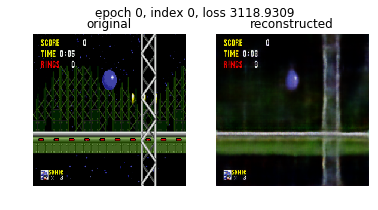

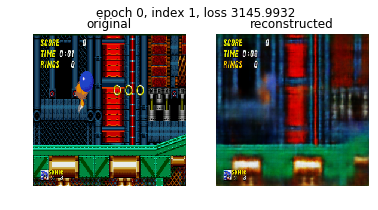

[3899/3900] loss=3975.2856



[974/975] loss=5754.8330

Epoch 1, loss=3975.2856, loss_val=5754.8330


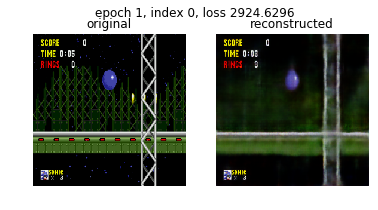

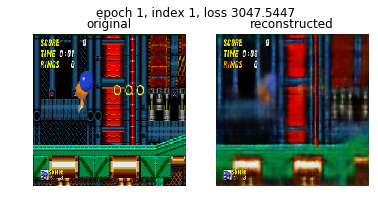

[3899/3900] loss=3838.0898



[974/975] loss=5672.1387

Epoch 2, loss=3838.0898, loss_val=5672.1387


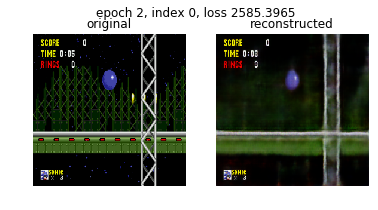

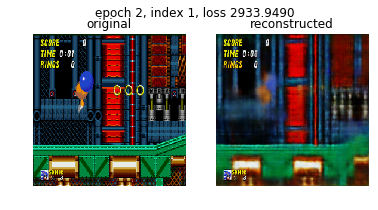

KeyboardInterrupt: 

In [16]:
for epoch in range(num_epochs): 
    info = train(loader_train, vae, optimizer, loss_function, test=False, cuda=True)
    info_val = train(loader_test, vae, optimizer, loss_function, test=True, cuda=True)
    scheduler.step(np.mean(info_val['loss']))
    
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f}'.format(epoch, np.mean(info['loss']), np.mean(info_val['loss'])))
    infos.append([info, info_val])
    
    plot_results(loader=loader_test, n=2, epoch=epoch)
    torch.save(vae.state_dict(), f'./models/{NAME}_{epoch}_state_dict.pkl')

try to get below 47-50 else go load last, and use lower learnign rate
also think if I need more latent channels?
 try leaving overnight
maybe I need a lower batch? lower than 6


Bigger model, with a diff archetecture (smaller code dim, large z_dim). It's looking blurry but let's see where it converges.
- 0: 17k
- 1: 14.7k
- 2: 13.4k
- 3: 12.5

73560.9062
43363.3125

117593.9766
105291.2500
68035.8281
59641.3555
48477.4297
16221.2061

In [22]:
torch.save(vae.state_dict(), f'./models/{NAME}_state_dict.pkl')
# torch.save(vae, f'./models/{NAME}.pkl')

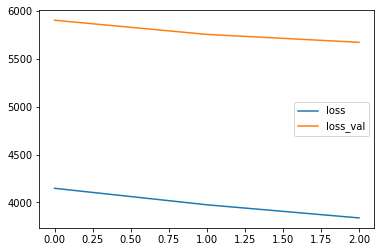

In [18]:
# plot history
import pandas as pd
histories = []
for info, info_val in infos:
    history = {k+'_val':np.mean(v) for k,v in info_val.items()}
    history.update({k:np.mean(v) for k,v in info.items()})
    histories.append(history)
histories = pd.DataFrame(histories)
histories.plot()

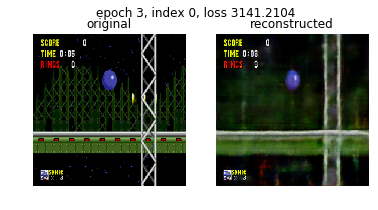

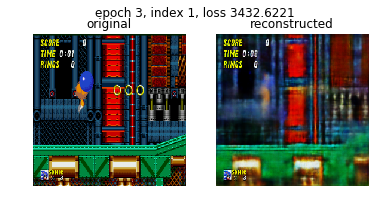

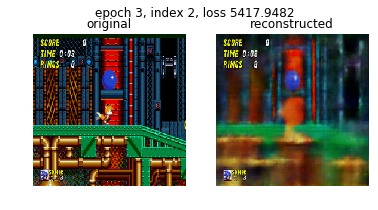

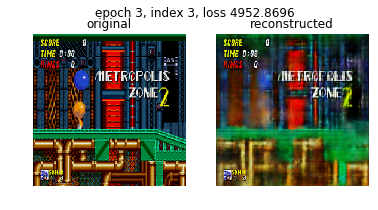

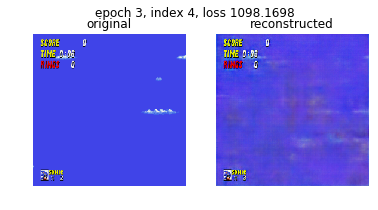

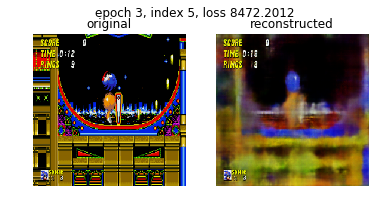

In [19]:
plot_results(loader=loader_test, n=6, epoch=epoch)

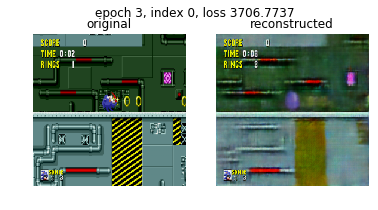

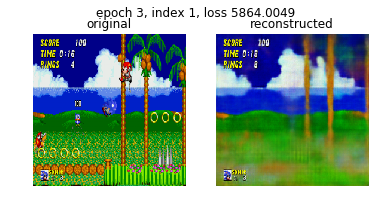

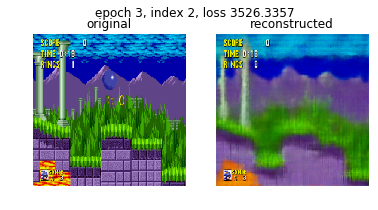

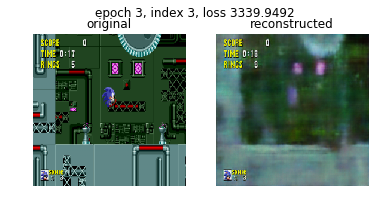

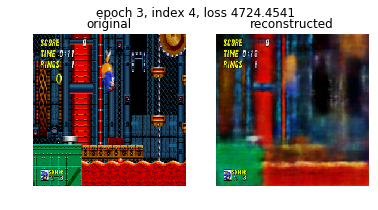

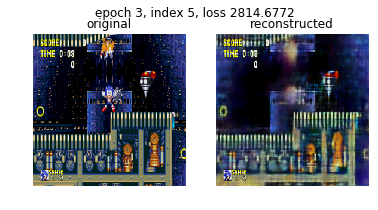

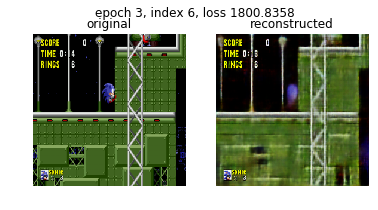

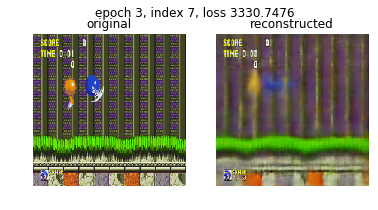

In [21]:
plot_results(loader=loader_train, n=8, epoch=epoch)

# End

In [ ]:
%time x=data_test[500]

In [ ]:
# DEBUG check chunk size
# should be less than 1e9
# should take more than 100ms, less than 1s
import itertools
x=data_train
shapes = list(itertools.product(*x.chunks))
nbytes = [x.dtype.itemsize * np.prod(shape) for shape in shapes]
assert nbytes[0]<1e9
nbytes[0]